In [62]:
# Setup dependencies (as taken from assignment 6)
import os
import math
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models

from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

#Additional Setup to use Tensorboard
!pip install -q tensorflow
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [137]:
df = pd.read_csv('day_ahead.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)
# df=df["Day-ahead Price [EUR/MWh]"].to_frame()
df

,Day-ahead Price [EUR/MWh],tempC,windspeedKmph,winddirDegree,precipMM,humidity,pressure,time_increment
datetime,,,,,,,,
2015-01-05 00:00:00,-0.243620,-1.722376,-0.422598,0.563889,0.000000,0.96,2.163731,2.4
2015-01-05 01:00:00,-0.316395,-1.722376,-0.297098,0.572222,0.000000,0.96,2.058525,0.1
2015-01-05 02:00:00,-0.439933,-1.722376,-0.171598,0.580556,0.000000,0.96,2.058525,0.2
2015-01-05 03:00:00,-0.625914,-1.722376,-0.046098,0.588889,0.000000,0.96,1.953318,0.3
2015-01-05 04:00:00,-0.626363,-1.722376,-0.171598,0.575000,0.000000,0.96,1.953318,0.4
...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,0.877205,-1.130468,-0.673599,0.602778,0.054545,0.94,-1.728907,1.9
2020-12-31 20:00:00,0.665169,-1.130468,-0.422598,0.625000,0.036364,0.93,-1.728907,2.0
2020-12-31 21:00:00,0.469755,-1.130468,-0.171598,0.650000,0.054545,0.93,-1.623701,2.1


# Create Torch dataset

In [138]:
# sequence length (edit the value for different sequence length)
seq = 24 

In [139]:
delta = pd.Timedelta(seq, unit ='h')
# define 1 hour object for convenience when using datetime as index in the dataframe to not include the last item
hours_12 = pd.Timedelta(12, unit ='h') # used mostly for empty 12 hours 
hour = pd.Timedelta(1, unit ='h')
day = pd.Timedelta(1, unit ='d')

In [140]:
### creating training dataset
train_y_start = dt.datetime(2015, 1, 5, 0, 0) + (delta+hours_12).ceil('1d')
#train_x_start = train_y_start - delta - hours_12
train_end = dt.datetime(2020, 11, 30, 23, 0)

train_x = []
train_y = []
while train_y_start + day - hour <= train_end:
    train_x_start = train_y_start - delta - hours_12
    
    
    #print(train_x_start, train_y_start)
    train_x.append(df[train_x_start:train_x_start+delta - hour].values)
    train_y.append(df[train_y_start:train_y_start+day - hour]['Day-ahead Price [EUR/MWh]'].values)
    
    train_y_start += day
    
train_x = np.asarray(train_x)
train_y = np.asarray(train_y)
print(train_x.shape)
print(train_y.shape)
print(train_x)
print(train_y)

(2155, 24, 8)
(2155, 24)
[[[ 2.90512388e-01 -1.13046846e+00 -2.97098198e-01 ...  7.40000000e-01
    1.63769895e+00  1.20000000e+00]
  [ 1.14864011e-01 -1.13046846e+00 -2.97098198e-01 ...  7.60000000e-01
    1.53249251e+00  1.30000000e+00]
  [ 7.59949251e-04 -1.27844545e+00 -2.97098198e-01 ...  7.90000000e-01
    1.53249251e+00  1.40000000e+00]
  ...
  [ 3.99225706e-01 -1.72237645e+00  7.94025123e-02 ...  7.20000000e-01
    6.90840990e-01  9.00000000e-01]
  [ 3.98776478e-01 -1.57439945e+00  2.04902749e-01 ...  6.90000000e-01
    6.90840990e-01  1.00000000e+00]
  [ 3.67779705e-01 -1.42642245e+00  3.30402986e-01 ...  6.50000000e-01
    6.90840990e-01  1.10000000e+00]]

 [[ 2.68949416e-01 -1.27844545e+00  4.55903223e-01 ...  6.10000000e-01
    6.90840990e-01  1.20000000e+00]
  [ 1.44513097e-01 -1.42642245e+00  4.55903223e-01 ...  6.20000000e-01
    6.90840990e-01  1.30000000e+00]
  [-2.39476231e-02 -1.42642245e+00  4.55903223e-01 ...  6.30000000e-01
    5.85634550e-01  1.40000000e+00]
  ..

In [141]:
### creating testing dataset
test_y_start = dt.datetime(2020, 12, 1, 0, 0)
test_end = dt.datetime(2020, 12, 31, 23, 0)

test_x = []
test_y = []
while test_y_start + day - hour <= test_end:
    test_x_start = test_y_start - delta - hours_12
    
    test_x.append(df[test_x_start:test_x_start+delta - hour].values)
    test_y.append(df[test_y_start:test_y_start+day - hour]['Day-ahead Price [EUR/MWh]'].values)
    
    test_y_start += day

test_x = np.asarray(test_x)
test_y = np.asarray(test_y)
print(test_x.shape)
print(test_y.shape)
print(test_x[0])

(31, 24, 8)
(31, 24)
[[ 0.19258056 -0.98249146 -0.42259844  0.16111111  0.          0.67
   0.79604743  1.2       ]
 [ 0.1225009  -0.98249146 -0.42259844  0.15277778  0.          0.66
   0.79604743  1.3       ]
 [ 0.08027341 -0.98249146 -0.54809867  0.14444444  0.          0.66
   0.79604743  1.4       ]
 [ 0.13373161 -0.98249146 -0.54809867  0.13611111  0.          0.65
   0.79604743  1.5       ]
 [ 0.31971225 -0.98249146 -0.54809867  0.13888889  0.          0.68
   0.79604743  1.6       ]
 [ 0.59194477 -1.13046846 -0.67359891  0.13888889  0.          0.71
   0.90125387  1.7       ]
 [ 0.73120563 -1.27844545 -0.67359891  0.14166667  0.          0.74
   0.90125387  1.8       ]
 [ 0.76310086 -1.27844545 -0.79909915  0.14444444  0.          0.76
   0.90125387  1.9       ]
 [ 0.62878151 -1.42642245 -0.79909915  0.15        0.          0.78
   0.90125387  2.        ]
 [ 0.46166848 -1.42642245 -0.92459938  0.15277778  0.          0.8
   1.00646031  2.1       ]
 [ 0.35609976 -1.42642245 -1.0

In [142]:
# create tensor objects
x_train = torch.from_numpy(train_x).float()
y_train = torch.from_numpy(train_y).float()
x_test = torch.from_numpy(test_x).float()
y_test = torch.from_numpy(test_y).float()
# train_loader = DataLoader(x_train,y_train, batch_size=128, shuffle=False)
# val_loader = DataLoader(x_test,y_test batch_size=128, shuffle=True)

# Define BLSTM model

In [143]:
class BLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, quantiles):
        super(BLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_dim*2, output_dim) # multiply hidden_dim by 2 because bidirectional
        
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        self.out_shape = len(quantiles)
        
        final_layers = [
            nn.Linear(hidden_dim*2, output_dim) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_() #hidden layer output
        # Initialize cell state
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_() 
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Index hidden state of last time step
#         _out = self.fc(out[:, -1, :])
        
        return torch.stack([layer(out[:, -1, :]) for layer in self.final_layers], dim=1)
        
        
#         return out

## Training

In [144]:
num_train = x_train.shape[0]
input_dim = x_train.shape[2]
output_dim = 24 
hidden_dim = 20 # no. of neurons in hidden layer
num_layers = 3 # no of hidden layers 
num_epochs = 10
print(x_train[i].unsqueeze(0))

tensor([[[ 0.1822, -0.5386,  1.3344,  0.6083,  0.2182,  0.8900, -1.2029,
           1.2000],
         [ 0.3485, -0.5386,  1.4599,  0.6111,  0.1091,  0.9000, -1.2029,
           1.3000],
         [ 0.1306, -0.5386,  1.5854,  0.6111,  0.0364,  0.9100, -1.2029,
           1.4000],
         [ 0.2672, -0.5386,  1.5854,  0.6139,  0.0545,  0.9200, -1.2029,
           1.5000],
         [ 0.2245, -0.5386,  1.2089,  0.6167,  0.0364,  0.9200, -1.2029,
           1.6000],
         [ 0.5821, -0.6865,  0.8324,  0.6194,  0.0000,  0.9200, -1.0977,
           1.7000],
         [ 0.3251, -0.6865,  0.4559,  0.6222,  0.0000,  0.9100, -0.9925,
           1.8000],
         [ 0.1975, -0.8345,  0.5814,  0.6139,  0.0000,  0.9200, -0.9925,
           1.9000],
         [ 0.0205, -0.8345,  0.7069,  0.6028,  0.0000,  0.9300, -0.9925,
           2.0000],
         [-0.3559, -0.8345,  0.9579,  0.5944,  0.0000,  0.9300, -0.8873,
           2.1000],
         [-0.3600, -0.8345,  0.9579,  0.5944,  0.0000,  0.9400, -0.992

In [145]:
# criterion = nn.MSELoss(reduction='mean')
# quatile loss implementation
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
#         print("inside QuantileLoss")
#         print(preds.size(0), target.size(0))
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, i]
            losses.append(
                torch.max(
                   (q-1) * errors, 
                   q * errors
            ).unsqueeze(1))
        loss = torch.mean(
            torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

quantiles = [.01,0.05, 0.10,0.25, .5, 0.75, 0.90, 0.95, .99]
criterion = QuantileLoss(quantiles)

model = BLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, quantiles=quantiles)
# for practice use MSE, in real experiment use NLLLOSS for parametric
print(model)

#criterion = nn.NLLLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

BLSTM(
  (lstm): LSTM(8, 20, num_layers=3, batch_first=True, bidirectional=True)
  (final_layers): ModuleList(
    (0): Linear(in_features=40, out_features=24, bias=True)
    (1): Linear(in_features=40, out_features=24, bias=True)
    (2): Linear(in_features=40, out_features=24, bias=True)
    (3): Linear(in_features=40, out_features=24, bias=True)
    (4): Linear(in_features=40, out_features=24, bias=True)
    (5): Linear(in_features=40, out_features=24, bias=True)
    (6): Linear(in_features=40, out_features=24, bias=True)
    (7): Linear(in_features=40, out_features=24, bias=True)
    (8): Linear(in_features=40, out_features=24, bias=True)
  )
)


In [146]:
# training loop
for t in range(num_epochs): 
    err = 0
    for i in range(num_train):
        y_train_pred = model(x_train[i].unsqueeze(0))
        
#         print(y_train_pred.shape)
        loss = criterion(torch.transpose(y_train_pred[0],0,1), y_train[i])
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        err += loss.item()
        #print("item ", t, "MSE: ", loss.item())
        
    print("Epoch ", t, "MSE: ", err/num_train)

Epoch  0 MSE:  1.0400294185929397
Epoch  1 MSE:  0.9168181493083175
Epoch  2 MSE:  0.8868074937928857
Epoch  3 MSE:  0.8752718689961666
Epoch  4 MSE:  0.8711249729320234
Epoch  5 MSE:  0.8660043282879477
Epoch  6 MSE:  0.8638298755178871
Epoch  7 MSE:  0.8614594287772743
Epoch  8 MSE:  0.8619410412632396
Epoch  9 MSE:  0.859546065026259


In [147]:

# Make the prediction on the meshed x-axis
model.eval()
with torch.no_grad():
    preds=model(x_test)

In [148]:
print(preds.shape)

torch.Size([31, 9, 24])


31


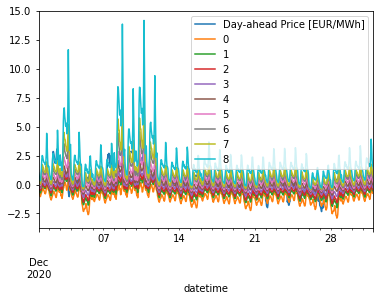

In [149]:
test_df = df[dt.datetime(2020, 12, 1, 0, 0):dt.datetime(2020, 12, 31, 23, 0)][['Day-ahead Price [EUR/MWh]']]
print(preds.shape[0])
for i in range(preds.shape[1]):
    y=preds[:,i,:]
    test_df[str(i)]=y.flatten()
test_df.plot()    

# y_lower, y_pred, y_upper = preds[:, 0,:], preds[:, 1,:], preds[:, 2,:],
# print(y_lower.shape)


# test_df['q1'] = y_lower.flatten()
# test_df['q2'] = y_pred.flatten()
# test_df['q3'] = y_upper.flatten()
# test_df.plot();


# Plot the function, the prediction and the 90% confidence interval based on
# # the MSE
# fig = plt.figure()
# plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
# plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
# plt.plot(xx, y_pred, 'r-', label=u'Prediction')
# plt.plot(xx, y_upper, 'k-')
# plt.plot(xx, y_lower, 'k-')
# plt.fill(np.concatenate([xx, xx[::-1]]),
#          np.concatenate([y_upper, y_lower[::-1]]),
#          alpha=.5, fc='b', ec='None', label='90% prediction interval')
# plt.xlabel('$x$')
# plt.ylabel('$f(x)$')
# plt.ylim(-10, 20)
# plt.legend(loc='upper left')
# plt.show()

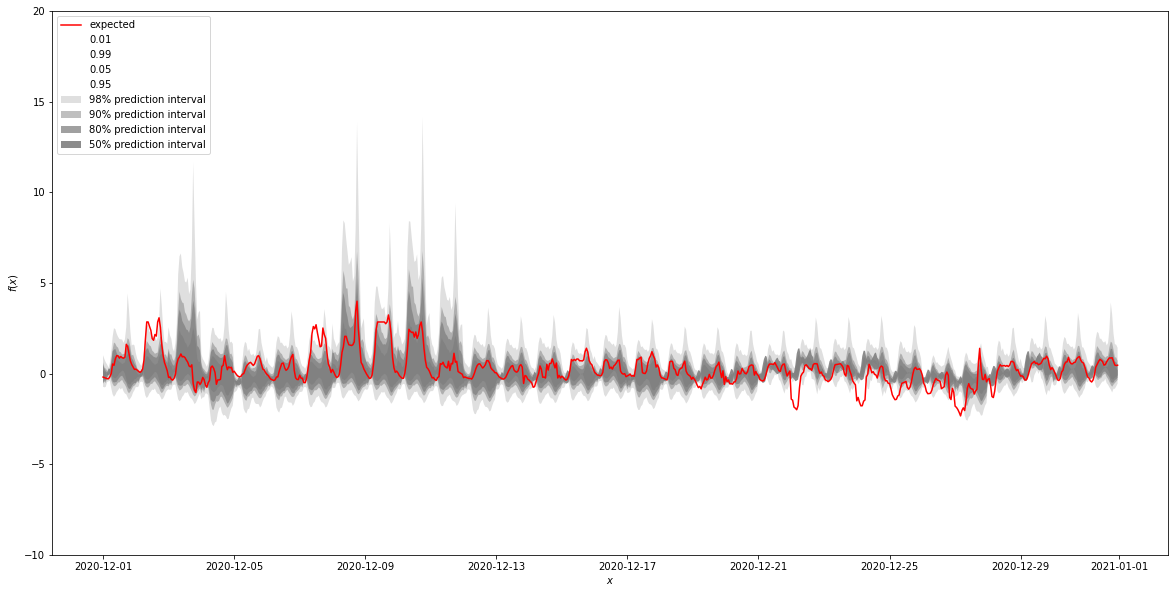

In [150]:
fig = plt.figure(figsize=(20,10))
plt.plot(test_df.index, test_df['Day-ahead Price [EUR/MWh]'].values, 'r', label='expected')

plt.plot(test_df.index, preds[:,0,:].flatten(), 'b,',markersize=0,label='0.01')
plt.plot(test_df.index, preds[:,8,:].flatten(), 'b.',markersize=0,label='0.99')

plt.plot(test_df.index, preds[:,1,:].flatten(), 'r.',markersize=0,label='0.05')
plt.plot(test_df.index, preds[:,7,:].flatten(), 'r.',markersize=0,label='0.95')

# plt.plot(test_df.index, y_pred, 'r-', label=u'Prediction')
# plt.plot(test_df.index, y_upper, 'k-')
# plt.plot(test_df.index, y_lower, 'k-')
plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([preds[:,8,:].flatten(), preds[:,0,:].flatten()]),
         alpha=.25, fc='grey', ec='None', label='98% prediction interval')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([preds[:,7,:].flatten(), preds[:,1,:].flatten()]),
         alpha=.5, fc='grey', ec='None', label='90% prediction interval')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([preds[:,6,:].flatten(), preds[:,2,:].flatten()]),
         alpha=.75, fc='grey', ec='None', label='80% prediction interval')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([preds[:,5,:].flatten(), preds[:,3,:].flatten()]),
         alpha=0.9, fc='grey', ec='None', label='50% prediction interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

In [ ]:
# training old loop
for t in range(num_epochs): 
    
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

## NLLLoss example

In [ ]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])
output = loss(m(input), target)
output.backward()


# 2D loss example (used, for example, with image inputs)
N, C = 5, 4
loss = nn.NLLLoss()
# input is of size N x C x height x width
data = torch.randn(N, 16, 10, 10)
conv = nn.Conv2d(16, C, (3, 3))
m = nn.LogSoftmax(dim=1)
# each element in target has to have 0 <= value < C
target = torch.empty(N, 8, 8, dtype=torch.long).random_(0, C)
output = loss(m(conv(data)), target)
print(target)
print(m(conv(data)))
print(output.item())
output.backward

# Plot